In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import datetime as dt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date,Open,High,Low,Close,Adj Close,Volume,DJI,Norm_Close,Event,Norm_Close_Change
0,2014-01-02,138.050003,139.000000,137.610001,138.130005,121.803711,3052100.0,16441.349609,0.008401,False,NaN
1,2014-01-03,138.369995,138.880005,138.029999,138.449997,122.085938,2133300.0,16469.990234,0.008406,False,0.000574
2,2014-01-06,138.750000,139.289993,137.479996,137.630005,121.362839,2712100.0,16425.099609,0.008379,False,-0.003206
3,2014-01-07,137.449997,138.199997,137.130005,137.649994,121.380447,2525500.0,16530.939453,0.008327,False,-0.006258
4,2014-01-08,137.479996,137.750000,136.339996,136.630005,120.481033,3122700.0,16462.740234,0.008299,False,-0.003298


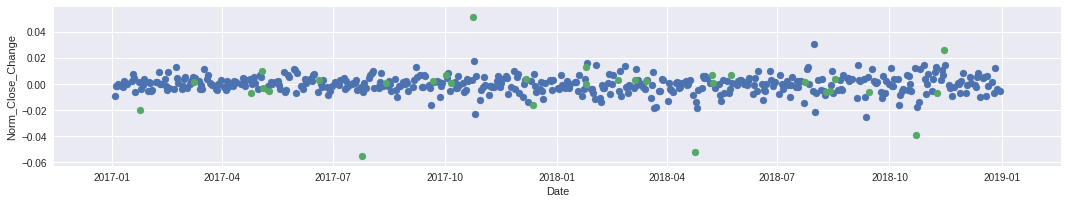

In [4]:
#@itle Data Loading

file_names = {'bayer': 'BAYZF.csv', '3M': 'MMM.csv', 'honeywell': 'HON.csv', 'synchrony': 'SYF.csv'}
data = {}

dji_data = pd.read_csv('DJI.csv', usecols=['Date', 'Close'])
dji_data.columns = ['Date', 'DJI']
dji_data.Date = pd.to_datetime(dji_data.Date)

event_data = pd.read_csv('multiTimeline.csv', usecols=['Date', 'Event'])
event_data.Date = pd.to_datetime(event_data.Date)

for k, v in file_names.items():
    data[k] = pd.read_csv(v)
    data[k].Date = pd.to_datetime(data[k].Date)
    
    date_mask = (data[k].Date > pd.Timestamp(2014, 1, 1))
    data[k] = data[k].loc[date_mask]

    data[k] = data[k].merge(dji_data, on='Date', how='left')
    data[k]['Norm_Close'] = data[k].Close / data[k].DJI

data['3M'] = data['3M'].merge(event_data, on='Date', how='left')
data['3M'].Event[~data['3M'].Event.isnull()] = True
data['3M'].Event[data['3M'].Event.isnull()] = False
# data['3M'].Event.value_counts()
data['3M']['Norm_Close_Change'] = data['3M'].Norm_Close.pct_change()

fg = sns.FacetGrid(data=data['3M'].loc[data['3M'].Date > pd.Timestamp(2017, 1, 1)], hue='Event', aspect=5)
fg.map(plt.scatter, 'Date', 'Norm_Close_Change')
# plt.ylim(0.005, 0.015)

data['3M'].head()

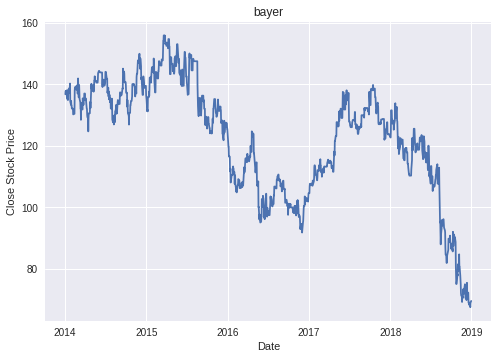

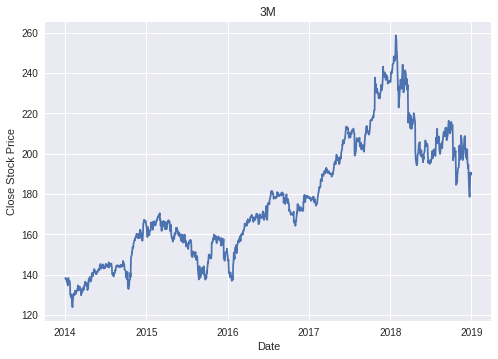

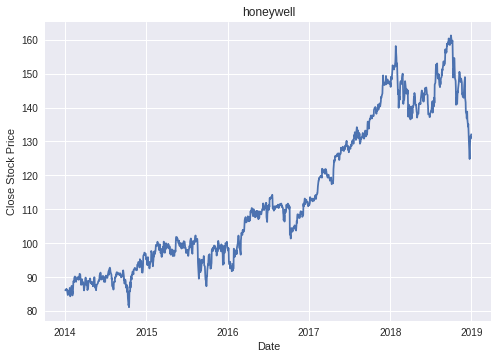

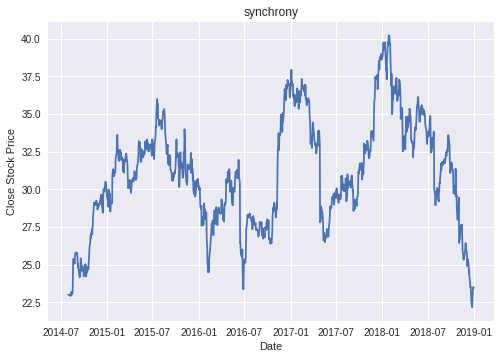

In [5]:
#@title Close Prices without Normalization

raw_figs = {}
for k, v in data.items():
    raw_figs[k] = plt.figure()
    plt.plot(data[k].Date, data[k].Close)
    plt.title(k)
    plt.xlabel('Date')
    plt.ylabel('Close Stock Price')
    raw_figs[k].show()

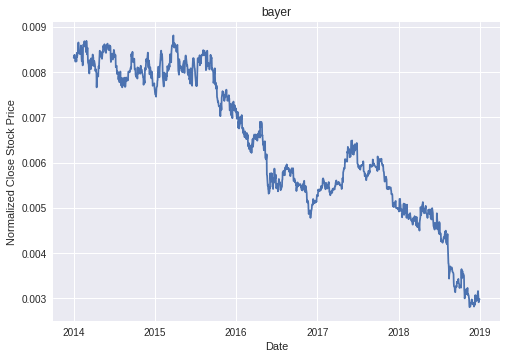

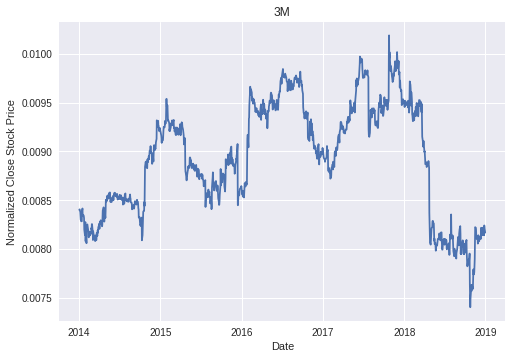

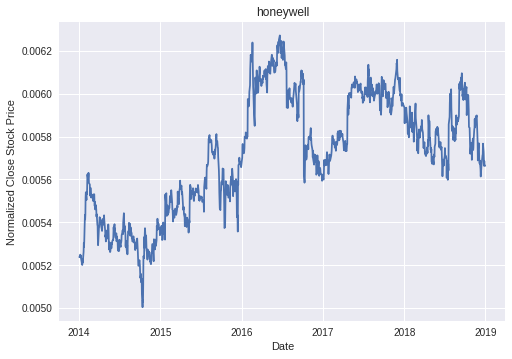

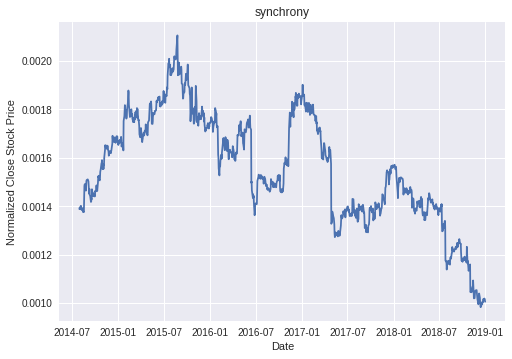

In [6]:
#@title Close Price with DJI Normalization

norm_figs = {}
for k, v in data.items():
    norm_figs[k] = plt.figure()
    plt.plot(data[k].Date, data[k].Norm_Close)
    plt.title(k)
    plt.xlabel('Date')
    plt.ylabel('Normalized Close Stock Price')
    norm_figs[k].show()

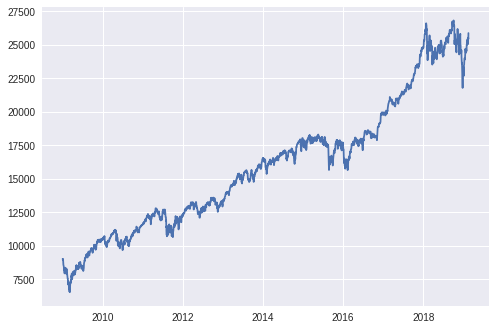

In [7]:
#@title DJI Data

plt.plot(dji_data.Date, dji_data.DJI)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


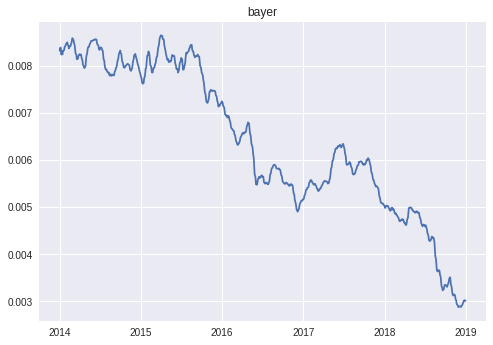

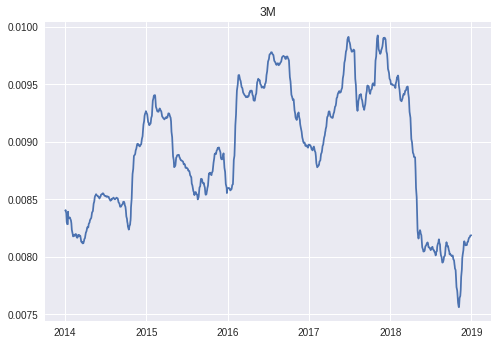

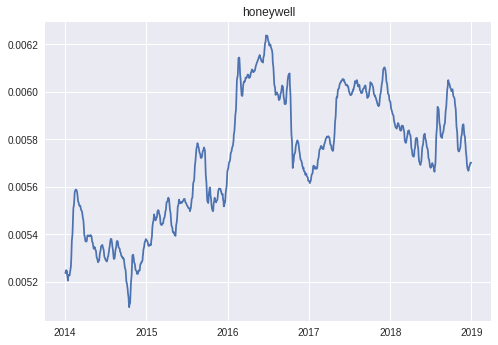

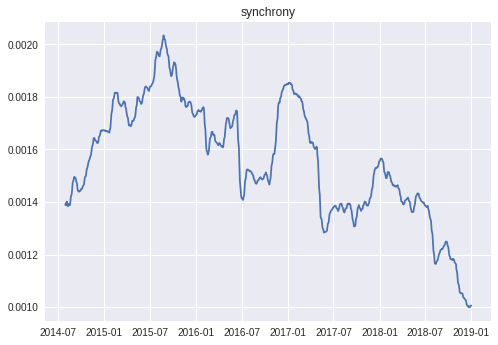

In [8]:
roll_avg_figs = {}
for k, v in data.items():
    w = 10
    data[k]['Norm_Close_Roll_Avg'] = data[k]['Norm_Close'].rolling(window=w).mean()
    data[k]['Norm_Close_Roll_Avg'].iloc[:w-1] = data[k]['Norm_Close'].iloc[:w-1]
    roll_avg_figs[k] = plt.figure()
    plt.plot(data[k].Date, data[k].Norm_Close_Roll_Avg)
    plt.title(k)
    roll_avg_figs[k].show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.


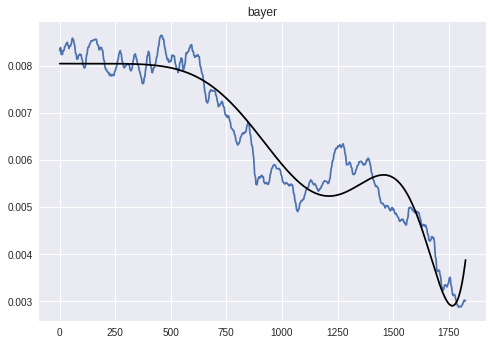

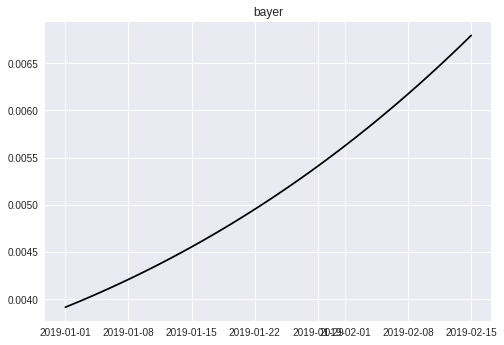

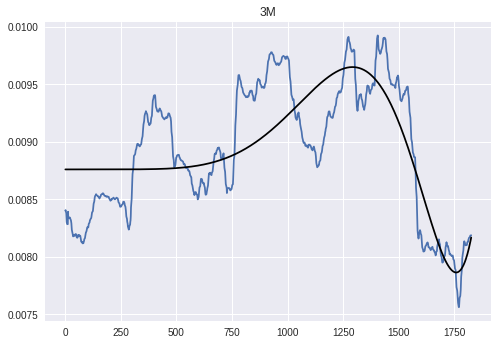

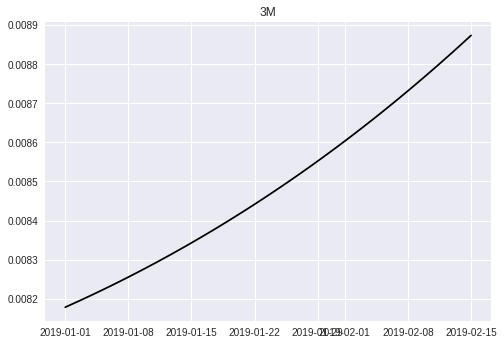

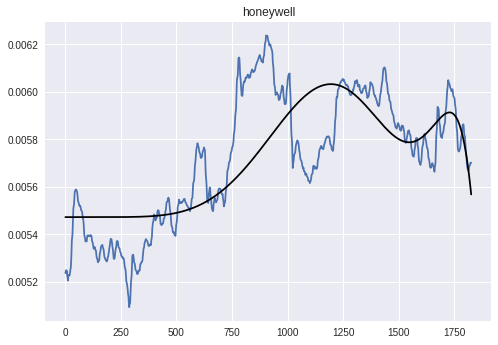

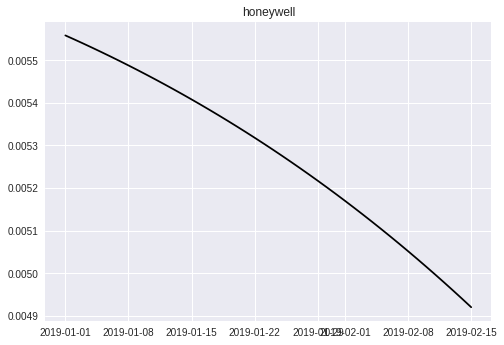

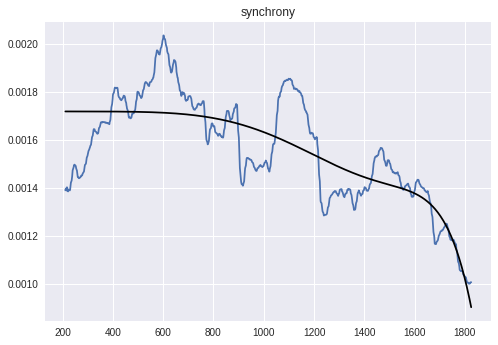

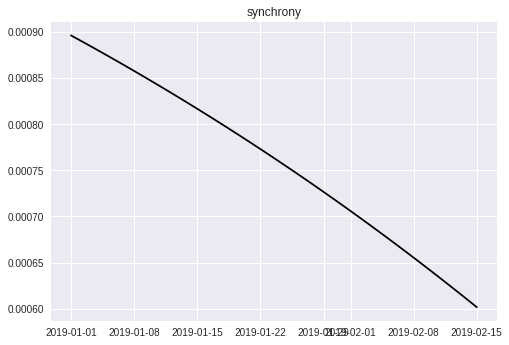

In [25]:
start_date = np.datetime64('2014-01-01T00:00:00Z')

def date_to_int(nparr):
    result = np.zeros(nparr.shape)
    for i, x in enumerate(nparr):
        result[i] = (x - start_date) / np.timedelta64(1, 'D') 
    return result


pred = {}
X = [np.datetime64('2019-01-{}'.format(i+1)) if i+1 > 9 else np.datetime64('2019-01-0{}'.format(i+1)) for i in range(31)]
X += [np.datetime64('2019-02-{}'.format(i+1)) if i+1 > 9 else np.datetime64('2019-02-0{}'.format(i+1)) for i in range(15)]
X = np.array(X)
for k, v in data.items():
    dates = date_to_int(data[k].Date.values).reshape(-1, 1)
    avgs = data[k].Norm_Close_Roll_Avg.values

    poly = PolynomialFeatures(degree=10).fit_transform(dates)

    reg = LinearRegression().fit(poly, avgs)

    plt.plot(dates, avgs)
    plt.plot(dates, reg.predict(poly), color='k')
    plt.title(k)
    plt.show()

    datesX = date_to_int(X).reshape(-1, 1)
    polyX = PolynomialFeatures(degree=10).fit_transform(datesX)
    pred[k] = reg.predict(polyX)
    plt.plot(X, pred[k], color='k')
    plt.title(k)
    plt.show()

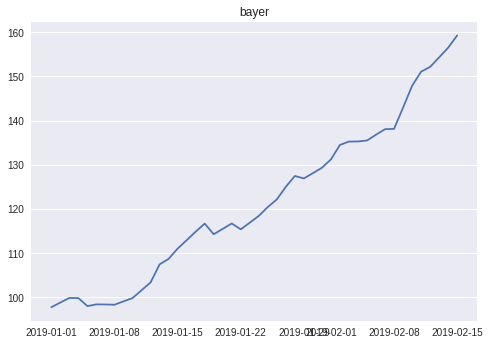

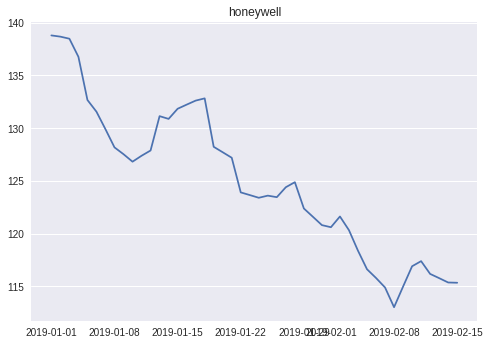

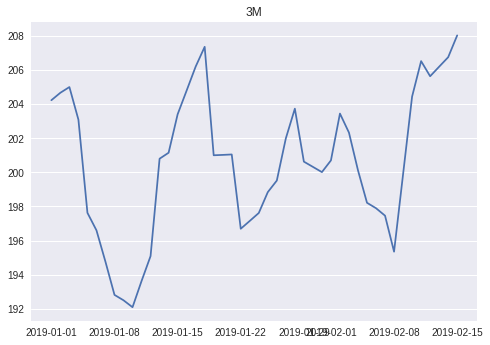

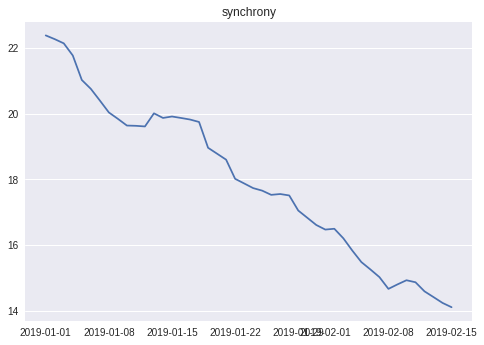

In [56]:
dji_pred = pd.read_csv('dji_predict.csv', usecols=['newtime', 'pd'])

final_pred = {}
for k, v in pred.items():
    df = pd.concat([pd.DataFrame(data=X, columns=['Date']), pd.DataFrame(data=v, columns=['Pred'])], axis=1)
    df.Pred = df.Pred * dji_pred.pd
    final_pred[k] = df


alp_order = ['bayer', 'honeywell', '3M', 'synchrony']
final_result = []
for a in alp_order:
    final_result.extend(list(final_pred[a].Pred.values))
    plt.plot(final_pred[a].Date, final_pred[a].Pred)
    plt.title(a)
    plt.gca().xaxis.grid(False)
    plt.show()

pd.DataFrame(np.array(final_result).reshape(-1, 1)).to_csv('Team9_Undergrad.csv', header=False, index=False)

In [51]:
comp = np.array(alp_order).reshape(-1,1)
growth = []
for a in alp_order:
    growth.append((final_pred[a].Pred.values[-1] - final_pred[a].Pred.values[0]) / final_pred[a].Pred.values[0])
growth = np.array(growth).reshape(-1,1)
growth_rate = np.concatenate([comp, growth], axis=1)
pd.DataFrame(data=growth_rate, columns=['Company', 'Stock Growth Rate'])

,Company,Stock Growth Rate
0,bayer,0.6285189746203373
1,honeywell,-0.16899321026588407
2,3M,0.01858456814841282
3,synchrony,-0.3698879866437698
